In [217]:
import pandas
import numpy as np
import pylab as plt
import math
%matplotlib inline

RAND = 228

In [218]:
features = pandas.read_csv('features.csv', index_col='match_id')
features.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-84.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,3.000000,2.000000,0.000000,-31.000000,1818.000000,0.000000,36.000000,256.000000,3.000000,3.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,3.000000,2.000000,1.000000,-16.000000,2268.000000,1.000000,1824.000000,1798.000000,63.000000,60.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,4.000000,3.000000,1.000000,8.000000,2778.000000,1.000000,1974.000000,1974.000000,63.000000,63.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,9.000000,9.000000,13.000000,300.000000,8452.000000,1.000000,2047.000000,2047.000000,63.000000,63.000000


In [219]:
size = len(features)
skip = features.describe().T['count']
skip = skip[skip < size]
skip = skip.apply(lambda x: (size - x) / size).sort_values(ascending=False)
skip

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
Name: count, dtype: float64

## Объяснение пропусков:

- first_blood_player2 --- в 45% случаях первая кровь зависила лишь от одного игрока.
- first_blood_time --- в 20% случаях первая кровь не наступала в первые 5 минут игры.

# Предобработка данных

In [220]:
train = features.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1)
X = train[train.columns[:-1]]
y = train['radiant_win']

Целевая переменная --- *radiant_win*

## Очистка

In [221]:
all_heroes = [team + str(x) + '_hero' for x in range(1, 6) for team in ['r', 'd']]

def clean(data):
    return data.fillna(0)

def clean_categorie(data):
    return data.drop(['lobby_type'] + all_heroes, axis=1)

In [222]:
X = clean(X)

# Градиентный бустинг

In [223]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
import time
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [224]:
rates = [0.05, 0.1]
nums = [10, 20, 30, 50, 80]

kfl = KFold(random_state=RAND, n_splits=5, shuffle=True)
scores = [[], []]

for i, learning_rate in enumerate(rates):
    print('learning_rate={0}'.format(learning_rate))
    for n_estimators in nums:
        gbc = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators)
        
        start_time = datetime.datetime.now()
        score = mean(cross_val_score(gbc, X, y, cv=kfl, scoring='roc_auc', n_jobs=-1))
        scores[i].append(score)
        
        time = datetime.datetime.now() - start_time
        
        print('n_estimators={0}. Score={1}. Time elapsed: {2}'.format(
            n_estimators, 
            score, 
            time
        ))

learning_rate=0.05
n_estimators=10. Score=0.6408695866609053. Time elapsed: 0:00:31.800444
n_estimators=20. Score=0.6683671322281609. Time elapsed: 0:00:48.698431
n_estimators=30. Score=0.6788474766061897. Time elapsed: 0:01:09.386536
n_estimators=50. Score=0.6879389734656856. Time elapsed: 0:01:43.788844
n_estimators=80. Score=0.6949820168728108. Time elapsed: 0:02:44.105455
learning_rate=0.1
n_estimators=10. Score=0.6646757963296153. Time elapsed: 0:00:24.112495
n_estimators=20. Score=0.6822875028354228. Time elapsed: 0:00:49.872460
n_estimators=30. Score=0.689296227196561. Time elapsed: 0:01:11.011396
n_estimators=50. Score=0.6968877763372511. Time elapsed: 0:01:46.703417
n_estimators=80. Score=0.7037036897411623. Time elapsed: 0:02:41.273506


При количестве деревьев равных 30.

Время кросс-валидации: 1:33

Качество: 0.689

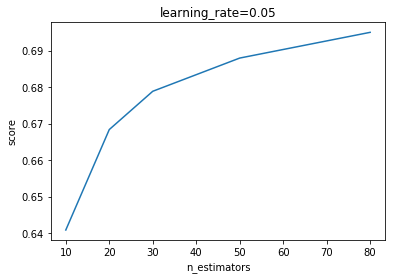

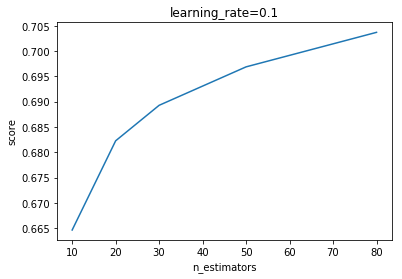

In [225]:
for i, val in enumerate(rates):
    plt.plot(nums, scores[i])
    plt.xlabel('n_estimators')
    plt.ylabel('score')
    plt.title('learning_rate={0}'.format(val))
    plt.show()

Как видно из графиков, использование количества деревьев больше 30 приводит к лучшему результату.

Для ускорения решения имеет смысл уменьшить глубину деревьев в градиентом бустинге (max_depth), либо используйте для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество.

# Логистическая регрессия

In [226]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

C=1e-05. Score=0.6951769692945798. Time elapsed: 0:00:08.539618
C=0.0001. Score=0.7113103783522267. Time elapsed: 0:00:09.662878
C=0.001. Score=0.7162626658328097. Time elapsed: 0:00:10.054699
C=0.01. Score=0.7164370423607987. Time elapsed: 0:00:11.432168
C=0.1. Score=0.7164134926861443. Time elapsed: 0:00:11.477995
C=1.0. Score=0.7164099830055872. Time elapsed: 0:00:11.763271
C=10.0. Score=0.716409415358991. Time elapsed: 0:00:11.870568
C=100.0. Score=0.7164093730372583. Time elapsed: 0:00:11.817834
C=1000.0. Score=0.7164093582002996. Time elapsed: 0:00:11.685028
C=10000.0. Score=0.7164093730227516. Time elapsed: 0:00:11.583133
C=100000.0. Score=0.7164093730227516. Time elapsed: 0:00:11.640803


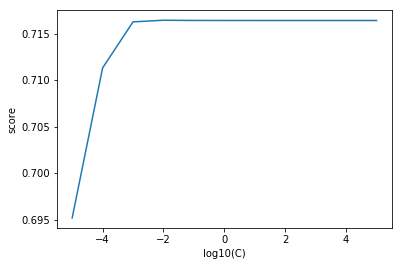

In [227]:
scale_X = scale_data(X)


def lr_score(X, y, C_grid):
    kfl = KFold(random_state=RAND, n_splits=5, shuffle=True)
    scores = []

    for C in C_grid:
        lg = LogisticRegression(C=C, random_state=RAND)

        start_time = datetime.datetime.now()
        score = mean(cross_val_score(lg, X, y, cv=kfl, scoring='roc_auc', n_jobs=-1))
        scores.append(score)

        time = datetime.datetime.now() - start_time

        print('C={0}. Score={1}. Time elapsed: {2}'.format(
            C, 
            score, 
            time
        ))
    return scores


def lr_process(X, y):
    C_grid = np.power(10.0, np.arange(-5, 6))
    scores = lr_score(X, y, C_grid)
    
    plt.plot(np.log10(C_grid), scores)
    plt.xlabel('log10(C)')
    plt.ylabel('score')
    plt.show()
    
    
lr_process(scale_X, y)

Наилучшее качество достигается при C=0.1 и равно 0.716413.

Результат лучше, чем градиентный бустинг при 80 деревьев. Решение работает в разы быстрее.

## Очистка категориальных признаков

C=1e-05. Score=0.6951110175213984. Time elapsed: 0:00:07.462254
C=0.0001. Score=0.7112861288356834. Time elapsed: 0:00:08.093764
C=0.001. Score=0.7162750689275057. Time elapsed: 0:00:09.683497
C=0.01. Score=0.7164537824619709. Time elapsed: 0:00:10.985197
C=0.1. Score=0.7164281625494288. Time elapsed: 0:00:11.093179
C=1.0. Score=0.7164251446917627. Time elapsed: 0:00:11.112380
C=10.0. Score=0.7164247122599274. Time elapsed: 0:00:11.584675
C=100.0. Score=0.7164245131121989. Time elapsed: 0:00:11.175492
C=1000.0. Score=0.7164244855679238. Time elapsed: 0:00:11.192221
C=10000.0. Score=0.7164244813313776. Time elapsed: 0:00:12.481352
C=100000.0. Score=0.7164244834518702. Time elapsed: 0:00:11.670873


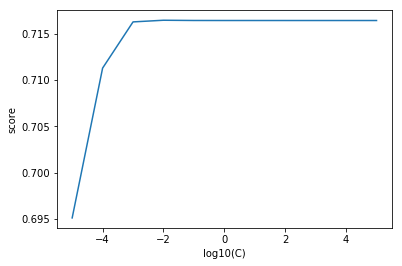

In [228]:
clean_X = scale_data(clean_categorie(X))
lr_process(clean_X, y)

Наилучшее качество достигается при C=0.1 и равно 0.716428.

При очистки категориальных признаков результат почти не изменился. Модель приспособилась под них.

In [229]:
heroes = []
for v in all_heroes:
    heroes = np.hstack([heroes, X[v].get_values()])
    
count_heroes = int(max(heroes))
print('В данные входят %d героев' % count_heroes)

В данные входят 112 героев


In [230]:
# добавления мешка слов

def bag_word_transform(X):
    new_X = scale_data(clean_categorie(X))
    X_pick = np.zeros((X.shape[0], count_heroes))

    for i, match_id in enumerate(X.index):
        for p in range(1, 6):
            X_pick[i, X.ix[match_id, 'r%d_hero' % p] - 1] = 1
            X_pick[i, X.ix[match_id, 'd%d_hero' % p] - 1] = -1
    new_X = np.hstack([new_X, X_pick])
    return new_X

new_X = bag_word_transform(X)

E:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


C=1e-05. Score=0.6992182373866199. Time elapsed: 0:00:08.461649
C=0.0001. Score=0.7250221113316808. Time elapsed: 0:00:08.490931
C=0.001. Score=0.7462548020066256. Time elapsed: 0:00:11.490115
C=0.01. Score=0.7517224287381921. Time elapsed: 0:00:15.023066
C=0.1. Score=0.7519495370110515. Time elapsed: 0:00:16.918662
C=1.0. Score=0.7519381371507132. Time elapsed: 0:00:18.752448
C=10.0. Score=0.7519347133791103. Time elapsed: 0:00:20.043991
C=100.0. Score=0.7519340882401432. Time elapsed: 0:00:18.931631
C=1000.0. Score=0.7519341496928998. Time elapsed: 0:00:21.500479
C=10000.0. Score=0.7519340438573741. Time elapsed: 0:00:22.588775
C=100000.0. Score=0.7519343468741349. Time elapsed: 0:00:19.721790


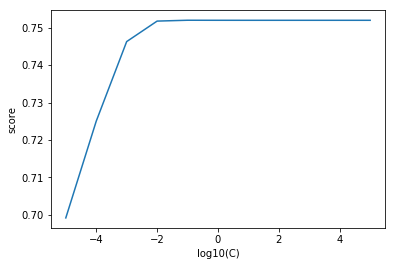

In [231]:
lr_process(new_X, y)

Наилучшее качество достигается при C=0.1 и равно 0.752.

Качество улучшилось. Были добавлены очень разреженные признаки, на которых хорошо работает логистическая регрессия.

In [232]:
def kaggle_save(name, model, data, transform):
    X_test = transform(data)
    y_test = model.predict_proba(X_test)[:, 1]
    print(min(y_test), max(y_test))
    result = pandas.DataFrame({'radiant_win': y_test}, index=data.index)
    result.index.name = 'match_id'
    result.to_csv('{}.csv'.format(name))

test_data = pandas.read_csv('features_test.csv', index_col='match_id')

lg = LogisticRegression(C=0.1, random_state=RAND)
lg.fit(new_X, y)

kaggle_save('lr_bag', lg, test_data, lambda x: bag_word_transform(clean(x)))

E:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


# Отправляем решение на kaggle в соревнование: Dota 2: Win Probability Prediction.

Данный код получает 0.75526 очков на kaggle.